In [2]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import rasterio
import rasterio.mask
import numpy as np
import numpy.ma as ma
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import os
import shutil
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from pprint import pprint as pp


In [2]:
with rasterio.open('ndvi_masked.tiff', 'r') as src:
    img_arr = src.read(1)

In [3]:
# make nan values -1 for future masking
img_arr_prep = np.nan_to_num(img_arr, nan=-1.0)
img_norm = (img_arr_prep + 1.0) / 2.0 # normalize range of -1,1 to 0,1

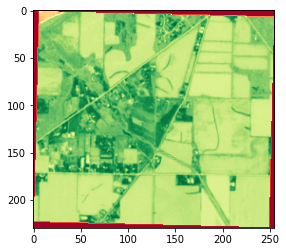

In [4]:
plt.imshow(img_norm, cmap="RdYlGn") # demo line, not needed


In [5]:
# custom colordict implementing transparent values of '0'
cdict = {'red':     ((0.0, 0.65, 0.65),
                    (0.25, 0.97, 0.97),
                    (0.5, 1.0, 1.0),
                    (0.75, 0.53, 0.53),
                    (1.0, 0.0, 0.0)),
        'green':   ((0.0, 0.0, 0.0),
                    (0.25, 0.55, 0.55),
                    (0.5, 1.0, 1.0),
                    (0.75, 0.80, 0.80),
                    (1.0, 0.41, 0.41)),
        'blue':   ((0.0, 0.15, 0.15),
                    (0.25, 0.32, 0.32),
                    (0.5, 0.75, 0.75),
                    (0.75, 0.4, 0.4),
                    (1.0, 0.22, 0.22)),
        'alpha':   ((0.0, 0.0, 0.0),
                    (0.02, 0.0, 1.0),
                    (0.03, 1.0, 1.0),
                    (1.0, 1.0, 1.0))}

mymap = colors.LinearSegmentedColormap('mymap', cdict)

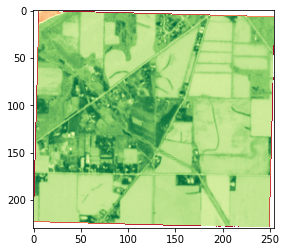

In [17]:
# test of mapping
plt.imshow(img_norm, cmap=mymap)

In [20]:
# prep of template to save a png with transparency and no border info
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.margins(0)
fig.add_axes(ax)

ax.imshow(img_norm, cmap=mymap)
plt.savefig("./pics/test2.png", transparent=True)
plt.close()

# Add further masking to minimize warping by cutting out only farm boundary

In [10]:
dst_crs = 'epsg:4326'

with rasterio.open('../data/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.SAFE/GRANULE/L2A_T16TCM_A016311_20200420T165055/IMG_DATA/R10m/T16TCM_20200420T163829_B04_10m.jp2', 'r') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'driver': 'GTiff'
    })

    with rasterio.open('full_wgs84.tif', 'w', **kwargs) as dst:
        reproject(source=rasterio.band(src, 1),
                  destination=rasterio.band(dst, 1),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=Resampling.nearest)

In [8]:
all_geom = gpd.read_file('farm_simple.geojson')
all_geom_m = all_geom.to_crs('epsg:32616')

In [19]:
paddock_mask = all_geom[all_geom.name == 'East 18 North']

with rasterio.open('./pics/ndvi_20200420.tiff', 'r') as src:
    paddock_data, _ = rasterio.mask.mask(src,
                                         paddock_mask.geometry,                                         
                                         nodata=0.0,
                                         all_touched=True,
                                         crop=True)
    paddock_mask_arr, _, _ = rasterio.mask.raster_geometry_mask(src,
                                                                paddock_mask.geometry,
                                                                all_touched=True,
                                                                crop=True)

x = np.ma.array(paddock_data[0], mask=paddock_mask_arr)
xnan = np.ma.filled(x, np.nan)

print('median - ', np.nanmedian(xnan))
print('mean - ', np.nanmean(xnan))
print('count - ', np.count_nonzero(paddock_data))

median -  0.7743104750777721
mean -  0.7400499947421516
count -  212


In [12]:
farm_mask = all_geom_m[all_geom_m.name == 'Farm boundary']

with rasterio.open('../data/S2B_MSIL2A_20200420T163829_N0214_R126_T16TCM_20200420T210016.SAFE/GRANULE/L2A_T16TCM_A016311_20200420T165055/QI_DATA/MSK_CLDPRB_20m.jp2', 'r') as cld_msk:
    cld_data, _ = rasterio.mask.mask(cld_msk,
                                         farm_mask.geometry,
                                         nodata=101,
                                         all_touched=True,
                                         crop=True)
    cld_mask_arr, _, _ = rasterio.mask.raster_geometry_mask(cld_msk,
                                                                farm_mask.geometry,
                                                                all_touched=True,
                                                                crop=True)

In [39]:
newdata = cld_data.squeeze() # removes from 'extra' dimension

616

In [35]:
newdata_mask = newdata != 101 # produces boolean mask

In [38]:
my_test = newdata[newdata_mask] #overlays boolean mask to produce single dimensional array of 'TRUE' masked values

In [44]:
np.count_nonzero(my_test) # checks 1D array for total number of values with possible clouds

36

In [10]:
paddock_mask = all_geom[all_geom.name == 'East 18 North']

with rasterio.open('./tmp_img/band04.tiff', 'r') as b4:
    b4_img, _ = rasterio.mask.mask(b4, paddock_mask.geometry, crop=True)

b4_squeeze = b4_img[0]

In [10]:
with rasterio.open('./pics/color_20200418.tiff', 'r') as infile:
    profile = infile.profile

    profile['Driver'] = 'PNG'
    profile['dtype'] = 'uint8'
    raster = infile.read()

    with rasterio.open('./pics/color_20200418.png', 'w', **profile) as outfile:
        outfile.write(raster.astype('uint8'))

In [28]:
farm_mask = all_geom[all_geom.name == 'Farm boundary']

with rasterio.open('./tmp_img/clouds.tiff', 'r') as cloud:
    cloud_data, _ = rasterio.mask.mask(cloud, farm_mask.geometry, crop=True, nodata=101)

cloud_data_mask = cloud_data < 101

cld_arr = cloud_data[cloud_data_mask]

print(np.max(cld_arr))
print(cld_arr.max())
print(np.count_nonzero(cld_arr))
print(np.percentile(cld_arr, 99))

0
0
0
0.0
